In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# 5 pollutants
TARGET_COLS = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

def make_feature_frame(df: pd.DataFrame,
                       target_cols=TARGET_COLS,
                       lags=(1, 6, 24),
                       ma_windows=(6, 12)) -> pd.DataFrame:
    """
    Input: preprocessed df (index = Datetime)
    Output: DataFrame with time features + lag & MA features for each pollutant
    """
    df_feat = df.copy()

    # Time features
    df_feat["hour"] = df_feat.index.hour
    df_feat["weekday"] = df_feat.index.weekday
    df_feat["month"] = df_feat.index.month

    # Generate lag & MA features for each pollutant
    for tgt in target_cols:
        for lag in lags:
            df_feat[f"{tgt}_lag_{lag}"] = df_feat[tgt].shift(lag)
        for w in ma_windows:
            df_feat[f"{tgt}_ma_{w}"] = df_feat[tgt].rolling(w, min_periods=1).mean()

    # Remove NaN caused by feature generation (first few rows)
    df_feat = df_feat.dropna()

    return df_feat

df = pd.read_csv(
    "clean_air_quality.csv",
    parse_dates=["Datetime"],
    index_col="Datetime"
)
df = df.drop(columns=["is_weekend"])
df_feat_all = make_feature_frame(df)
print("Feature frame shape:", df_feat_all.shape)
print(df_feat_all.head())

def year_split_2004_2005(X: np.ndarray, y: np.ndarray, index: pd.DatetimeIndex):
    """
    Split by year:
      - train: year 2004
      - test : year 2005
    """
    index = pd.DatetimeIndex(index)
    mask_train = index.year == 2004
    mask_test  = index.year == 2005

    X_train, X_test = X[mask_train], X[mask_test]
    y_train, y_test = y[mask_train], y[mask_test]
    idx_train, idx_test = index[mask_train], index[mask_test]

    return X_train, X_test, y_train, y_test, idx_train, idx_test

Feature frame shape: (9333, 36)
                     CO(GT)  NMHC(GT)  C6H6(GT)  NOx(GT)  NO2(GT)     T    RH  \
Datetime                                                                        
2004-03-11 18:00:00     4.8     307.0      20.8    281.0    151.0  10.3  64.2   
2004-03-11 19:00:00     6.9     461.0      27.4    383.0    172.0   9.7  69.3   
2004-03-11 20:00:00     6.1     401.0      24.0    351.0    165.0   9.6  67.8   
2004-03-11 21:00:00     3.9     197.0      12.8    240.0    136.0   9.1  64.0   
2004-03-11 22:00:00     1.5      61.0       4.7     94.0     85.0   8.2  63.4   

                         AH  hour  weekday  ...  NOx(GT)_lag_1  NOx(GT)_lag_6  \
Datetime                                    ...                                 
2004-03-11 18:00:00  0.8065    18        3  ...          243.0          104.0   
2004-03-11 19:00:00  0.8319    19        3  ...          281.0          146.0   
2004-03-11 20:00:00  0.8133    20        3  ...          383.0          207.

Feature frame shape for classification: (9333, 37)

===== Single-step CO_class classification (2004 -> 2005) =====
Logistic Regression accuracy: 0.8416
Random Forest accuracy       : 0.8451
H= 1 | Naive=0.7596 | LR=0.7364 | RF=0.7752 | XGB=0.7907
H= 6 | Naive=0.3971 | LR=0.5016 | RF=0.6109 | XGB=0.6194
H=12 | Naive=0.4027 | LR=0.5441 | RF=0.5736 | XGB=0.5875
H=24 | Naive=0.6091 | LR=0.5326 | RF=0.5776 | XGB=0.5848

===== Multi-step CO_class classification accuracy (2004 -> 2005) =====
   target  horizon  acc_naive    acc_lr    acc_rf   acc_xgb
0  CO(GT)        1   0.759573  0.736420  0.775156  0.790739
1  CO(GT)        6   0.397144  0.501562  0.610888  0.619366
2  CO(GT)       12   0.402685  0.544072  0.573602  0.587472
3  CO(GT)       24   0.609087  0.532614  0.577598  0.584795


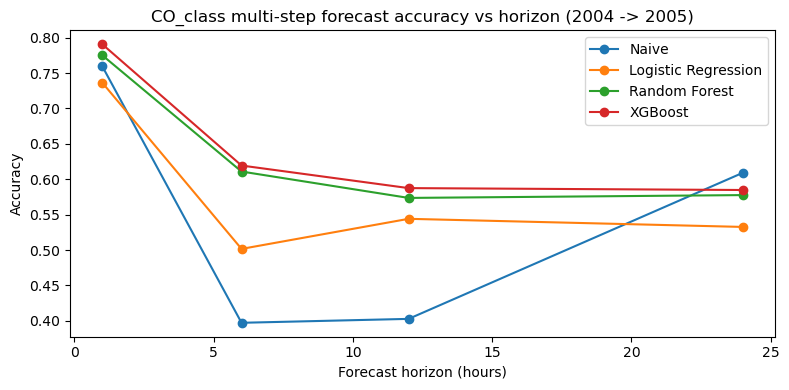


===== Confusion matrix (CO_class, horizon=6h, RF) =====
[[710 157 108]
 [180 157 271]
 [ 75  81 502]]

Classification report (RF, horizon=6h):
              precision    recall  f1-score   support

           0     0.7358    0.7282    0.7320       975
           1     0.3975    0.2582    0.3131       608
           2     0.5698    0.7629    0.6524       658

    accuracy                         0.6109      2241
   macro avg     0.5677    0.5831    0.5658      2241
weighted avg     0.5952    0.6109    0.5949      2241



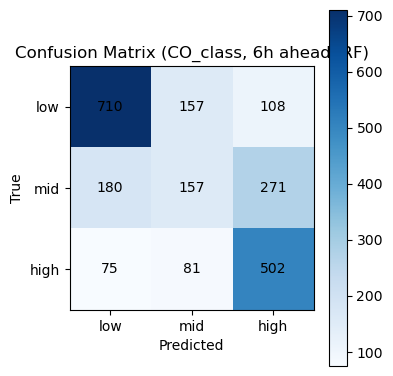

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)



def discretize_co(co_value: float) -> int:

    if co_value < 1.5:
        return 0
    elif co_value < 2.5:
        return 1
    else:
        return 2


def build_multistep_cls_dataset(df_feat: pd.DataFrame, horizon: int):

    df_tmp = df_feat.copy()

    future_col = f"CO_future_{horizon}"
    df_tmp[future_col] = df_tmp["CO(GT)"].shift(-horizon)

    future_cls_col = f"CO_future_{horizon}_class"
    df_tmp[future_cls_col] = df_tmp[future_col].apply(discretize_co)

    df_tmp = df_tmp.dropna(subset=[future_col, future_cls_col])

    y_future = df_tmp[future_cls_col].values.astype(int)

    y_naive = df_tmp["CO_class"].values.astype(int)

    cols_drop = ["CO(GT)", future_col, future_cls_col]
    feature_cols = [c for c in df_tmp.columns if c not in cols_drop]

    X = df_tmp[feature_cols].values
    idx = df_tmp.index

    return X, y_future, y_naive, feature_cols, idx


def main():
    df = load_and_preprocess_air_quality(Path(DATA_PATH))

    df_feat_all = make_feature_frame(df)

    df_feat_all["CO_class"] = df_feat_all["CO(GT)"].apply(discretize_co)

    print("Feature frame shape for classification:", df_feat_all.shape)

    feature_cols_now = [
        c for c in df_feat_all.columns if c not in ["CO(GT)", "CO_class"]
    ]
    X_now = df_feat_all[feature_cols_now].values
    y_now = df_feat_all["CO_class"].values.astype(int)
    idx_now = df_feat_all.index

    X_tr_now, X_te_now, y_tr_now, y_te_now, idx_tr_now, idx_te_now = year_split_2004_2005(
        X_now, y_now, idx_now
    )

    scaler_now = StandardScaler()
    X_tr_now_s = scaler_now.fit_transform(X_tr_now)
    X_te_now_s = scaler_now.transform(X_te_now)

    clf_lr_now = LogisticRegression(max_iter=200)
    clf_lr_now.fit(X_tr_now_s, y_tr_now)
    pred_lr_now = clf_lr_now.predict(X_te_now_s)
    acc_lr_now = accuracy_score(y_te_now, pred_lr_now)

    clf_rf_now = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        random_state=42,
        n_jobs=-1,
    )
    clf_rf_now.fit(X_tr_now_s, y_tr_now)
    pred_rf_now = clf_rf_now.predict(X_te_now_s)
    acc_rf_now = accuracy_score(y_te_now, pred_rf_now)

    print("\n===== Single-step CO_class classification (2004 -> 2005) =====")
    print(f"Logistic Regression accuracy: {acc_lr_now:.4f}")
    print(f"Random Forest accuracy       : {acc_rf_now:.4f}")


    HORIZONS = [1, 6, 12, 24]
    results_multistep_cls = []

    for h in HORIZONS:
        X_h, y_future_h, y_naive_h, feat_h, idx_h = build_multistep_cls_dataset(
            df_feat_all, h
        )

        X_tr, X_te, y_tr, y_te, idx_tr, idx_te = year_split_2004_2005(
            X_h, y_future_h, idx_h
        )
        _, _, y_naive_tr, y_naive_te, _, _ = year_split_2004_2005(
            X_h, y_naive_h, idx_h
        )

        if len(X_tr) == 0 or len(X_te) == 0:
            print(f"[Warning] No data for horizon={h}, skip.")
            continue

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_te_s = scaler.transform(X_te)

        acc_naive = accuracy_score(y_te, y_naive_te)

        clf_lr = LogisticRegression(max_iter=200)
        clf_lr.fit(X_tr_s, y_tr)
        pred_lr = clf_lr.predict(X_te_s)
        acc_lr = accuracy_score(y_te, pred_lr)

        clf_rf = RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            random_state=42,
            n_jobs=-1,
        )
        clf_rf.fit(X_tr_s, y_tr)
        pred_rf = clf_rf.predict(X_te_s)
        acc_rf = accuracy_score(y_te, pred_rf)


        clf_xgb = XGBClassifier(
            n_estimators=600,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.9,
            objective="multi:softmax",
            num_class=3,
            random_state=42,
            n_jobs=-1,
        )
        clf_xgb.fit(X_tr_s, y_tr)
        pred_xgb = clf_xgb.predict(X_te_s)
        acc_xgb = accuracy_score(y_te, pred_xgb)


        results_multistep_cls.append(
            ("CO(GT)", h, acc_naive, acc_lr, acc_rf, acc_xgb)
        )

        print(
            f"H={h:2d} | Naive={acc_naive:.4f} | LR={acc_lr:.4f} | "
            f"RF={acc_rf:.4f} | XGB={acc_xgb:.4f}"
        )

    df_cls_multi = pd.DataFrame(
        results_multistep_cls,
        columns=["target", "horizon", "acc_naive", "acc_lr", "acc_rf", "acc_xgb"],
    )
    print("\n===== Multi-step CO_class classification accuracy (2004 -> 2005) =====")
    print(df_cls_multi)

    if not df_cls_multi.empty:
        df_plot = df_cls_multi.sort_values("horizon")

        plt.figure(figsize=(8, 4))
        plt.plot(df_plot["horizon"], df_plot["acc_naive"], marker="o", label="Naive")
        plt.plot(df_plot["horizon"], df_plot["acc_lr"], marker="o", label="Logistic Regression")
        plt.plot(df_plot["horizon"], df_plot["acc_rf"], marker="o", label="Random Forest")

        plt.plot(df_plot["horizon"], df_plot["acc_xgb"], marker="o", label="XGBoost")

        plt.xlabel("Forecast horizon (hours)")
        plt.ylabel("Accuracy")
        plt.title("CO_class multi-step forecast accuracy vs horizon (2004 -> 2005)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    h_demo = 6
    X_h, y_future_h, y_naive_h, feat_h, idx_h = build_multistep_cls_dataset(
        df_feat_all, h_demo
    )
    X_tr, X_te, y_tr, y_te, idx_tr, idx_te = year_split_2004_2005(
        X_h, y_future_h, idx_h
    )
    scaler_demo = StandardScaler()
    X_tr_s = scaler_demo.fit_transform(X_tr)
    X_te_s = scaler_demo.transform(X_te)

    clf_rf_demo = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        random_state=42,
        n_jobs=-1,
    )
    clf_rf_demo.fit(X_tr_s, y_tr)
    y_pred_demo = clf_rf_demo.predict(X_te_s)

    cm = confusion_matrix(y_te, y_pred_demo)
    print(f"\n===== Confusion matrix (CO_class, horizon={h_demo}h, RF) =====")
    print(cm)
    print("\nClassification report (RF, horizon=6h):")
    print(classification_report(y_te, y_pred_demo, digits=4))

    plt.figure(figsize=(4, 4))
    im = plt.imshow(cm, cmap="Blues")
    plt.colorbar(im)
    plt.title(f"Confusion Matrix (CO_class, {h_demo}h ahead, RF)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    ticks = [0, 1, 2]
    labels = ["low", "mid", "high"]
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()